In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

C:\Users\bhavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Load dataset
df = pd.read_csv(r"C:\Users\bhavy\Desktop\yahoo_stock.csv")



In [8]:
# Data Cleaning
# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [9]:
# Check for duplicates
df = df.drop_duplicates()

# Exploratory Data Analysis
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
               High          Low         Open        Close        Volume  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1.259000e+03   
mean   2663.044384  2635.095615  2649.846099  2650.022881  3.860726e+09   
std     410.772138   405.376943   408.069705   407.943926  9.980325e+08   
min    1847.000000  1810.099976  1833.400024  1829.079956  1.296540e+09   
25%    2351.229980  2330.729980  2342.255005  2343.084961  3.291220e+09   
50%    2702.840088  2674.139893  2686.100098  2689.860107  3.630490e+09   
75%    2930.645020  2902.209961  2915.750000  2917.449951  4.113345e+09   
max    3645.989990  3600.159912  3612.090088  3626.909912  9.044690e+09   

         Adj Close  
count  1259.000000  
mean   2650.022881  
std     407.943926  
min    1829.079956  
25%    2343.084961  
50%    2689.860107  
75%    2917.449951  
max    3626.909912  


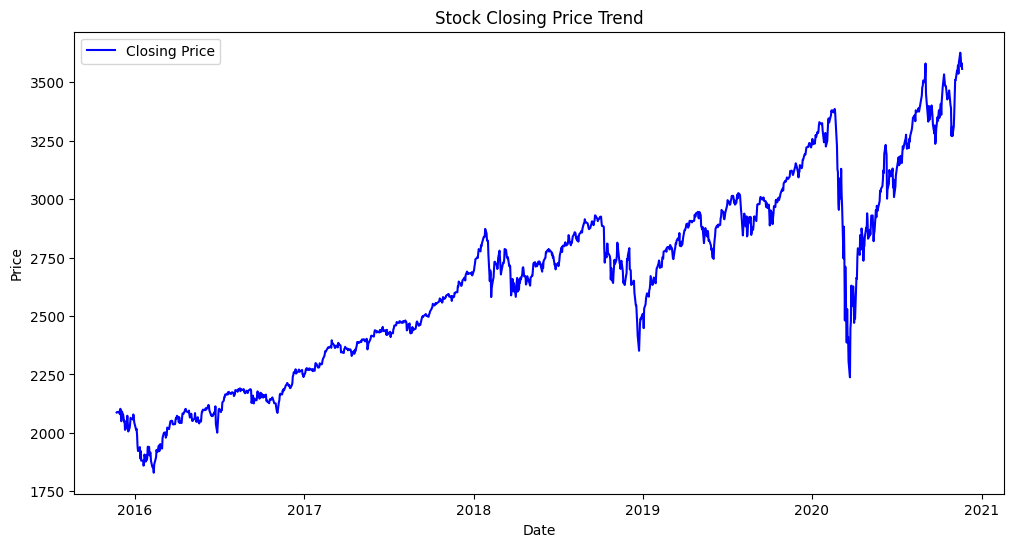

In [10]:

# Visualizing stock trends
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Closing Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Closing Price Trend')
plt.legend()
plt.show()


In [11]:
# Moving Averages
for ma in [20, 50, 100]:
    df[f'MA_{ma}'] = df['Close'].rolling(window=ma).mean()

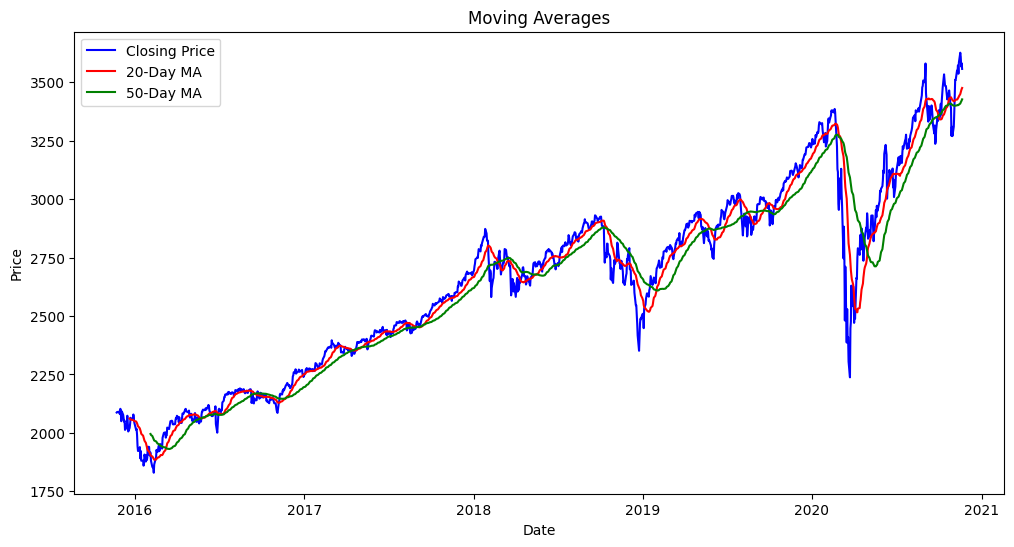

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Closing Price', color='blue')
plt.plot(df.index, df['MA_20'], label='20-Day MA', color='red')
plt.plot(df.index, df['MA_50'], label='50-Day MA', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Moving Averages')
plt.legend()
plt.show()


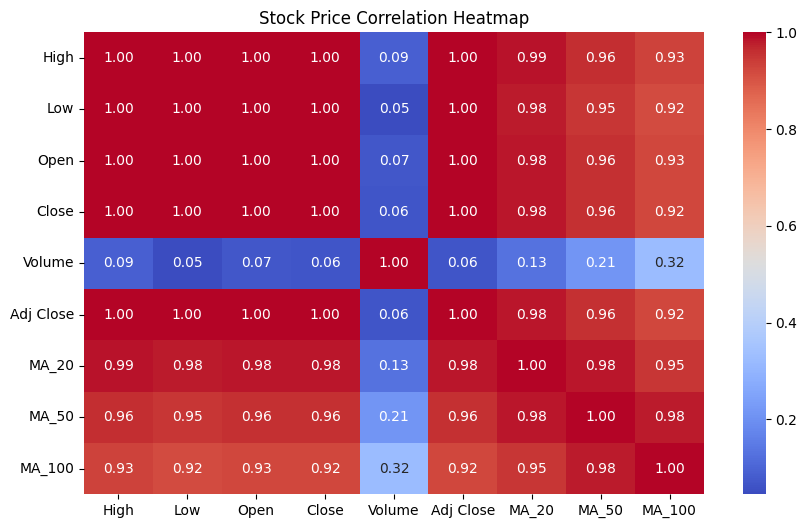

In [13]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Stock Price Correlation Heatmap")
plt.show()


In [14]:
# ARIMA Model (for short-term forecasting)
model_arima = ARIMA(df['Close'], order=(5,1,0))
model_arima_fit = model_arima.fit()
df['ARIMA_Forecast'] = model_arima_fit.predict(start=len(df)-30, end=len(df)-1, dynamic=False)

C:\Users\bhavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bhavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bhavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

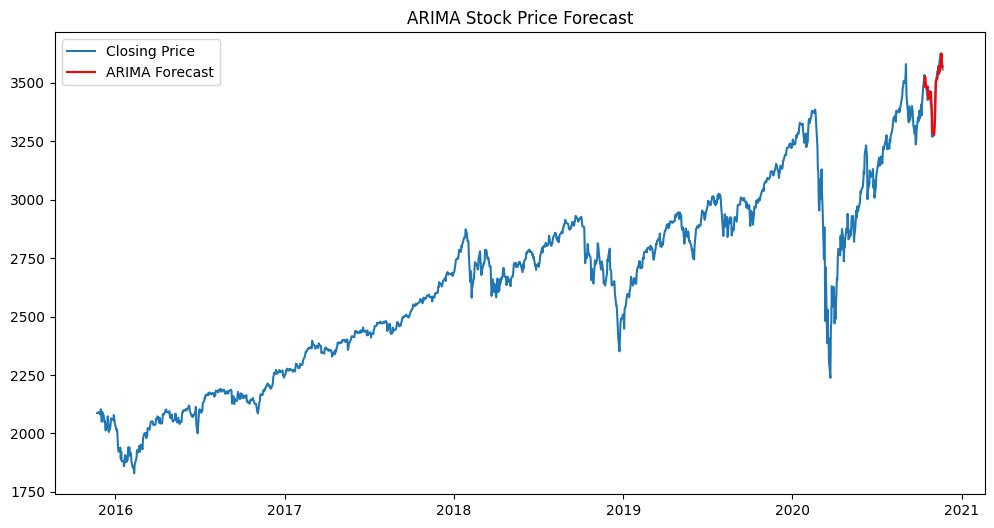

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Closing Price')
plt.plot(df.index[-30:], df['ARIMA_Forecast'][-30:], label='ARIMA Forecast', color='red')
plt.title('ARIMA Stock Price Forecast')
plt.legend()
plt.show()

19:46:30 - cmdstanpy - INFO - Chain [1] start processing
19:46:31 - cmdstanpy - INFO - Chain [1] done processing


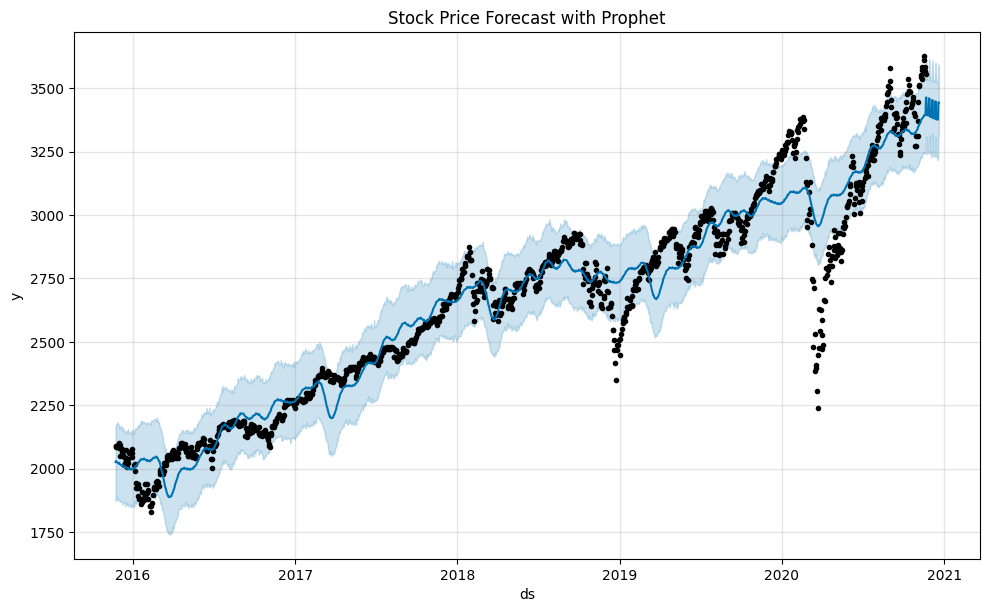

In [16]:
# Facebook Prophet Forecasting
df_prophet = df[['Close']].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

fig = prophet_model.plot(forecast)
plt.title("Stock Price Forecast with Prophet")
plt.show()


In [17]:
# LSTM Model for Deep Learning Forecasting
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['Close']])

X_train, y_train = [], []
for i in range(60, len(df_scaled)-30):
    X_train.append(df_scaled[i-60:i, 0])
    y_train.append(df_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [18]:
# Building LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

C:\Users\bhavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0554
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.3880e-04


In [19]:
# Predicting with LSTM
predicted_prices = model.predict(X_train)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


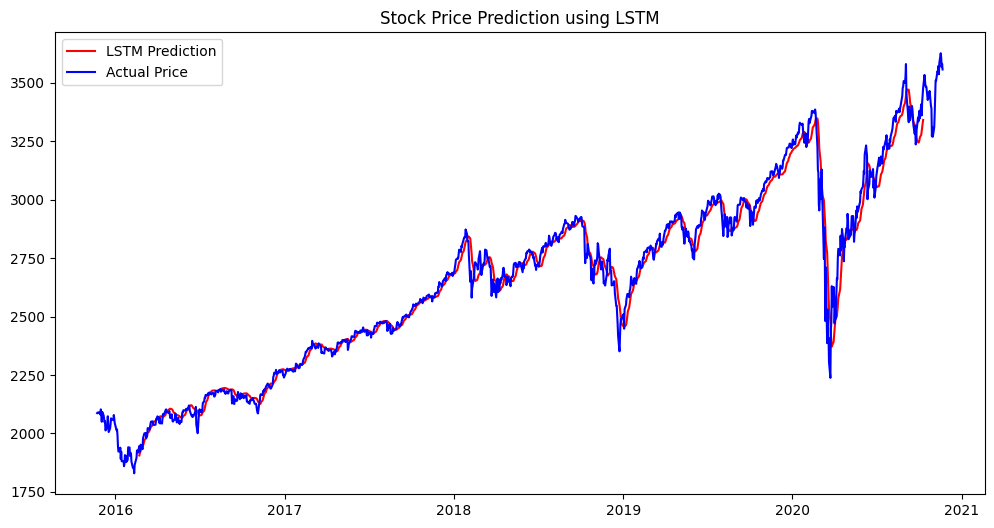

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[60:len(predicted_prices)+60], predicted_prices, label='LSTM Prediction', color='red')
plt.plot(df.index, df['Close'], label='Actual Price', color='blue')
plt.title('Stock Price Prediction using LSTM')
plt.legend()
plt.show()

In [21]:
# Business Insights
print("\nKey Insights:")
print("1. The stock shows an overall upward/downward trend based on moving averages.")
print("2. Volatility is observed in specific time periods, indicating potential investment risks.")
print("3. The LSTM model provides predictive insights but should be combined with other analysis methods for better decision-making.")



Key Insights:
1. The stock shows an overall upward/downward trend based on moving averages.
2. Volatility is observed in specific time periods, indicating potential investment risks.
3. The LSTM model provides predictive insights but should be combined with other analysis methods for better decision-making.
